In [60]:
# 导入所需库
import hashlib
import os
import tarfile
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

import datetime

# 下载数据

In [61]:
# 设置下载路径
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
# 下载函数
def download(name, cache_dir=os.path.join('data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
# 解压函数
def download_extract(name, folder=None):  
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [62]:
DATA_HUB['kaggle_house_train'] = (  
        DATA_URL + 'kaggle_house_pred_train.csv',
        '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
# 分别下载测试集和训练集
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))
test = test_data

In [63]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [64]:
train_data.shape

(1460, 81)

In [65]:
test_data.shape

(1459, 80)

In [66]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


# 数据预处理

In [67]:
#将列表中数值型的数据索引出来
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
#对数据进行标准化
all_features[numeric_features]=all_features[numeric_features].apply(
        lambda x:(x-x.mean())/(x.std()))
#标准化后，每个数值特征的均值变为0，可以直接用0来替换缺失值
all_features[numeric_features]=all_features[numeric_features].fillna(0)
#离散数值转成指示特征
all_features=pd.get_dummies(all_features,dummy_na=True)#通过转换将特征数从79增加到了330

In [68]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [69]:
#将数据转化为张量格式
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values,dtype = torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [70]:
train_features.shape

torch.Size([1460, 331])

In [71]:
train_labels.shape

torch.Size([1460, 1])

In [72]:
#区分训练集和测试机
msk = np.random.random(len(train_features)) < 0.8
#用80%的数据做训练集, 20%做测试集
train_alldatas = train_features
train_alllabels = train_labels
test_alldatas = test_features
train_datas = train_features[msk]
test_datas = train_features[~msk]
labels = train_labels
train_labels = labels[msk]
test_labels = labels[~msk]
#train_datas 划分完的train 百分之80
#train_labels
#train_alldatas 所有的train
#train_data 包含标签的所有的data

# 网络模型设计

In [73]:
#损失函数和网络
loss = nn.MSELoss()
in_features  = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,256),nn.ReLU(),nn.Linear(256,1))
    return net
    
# 降低房价误差大对模型的影响，即房价高的房子，预测值和实际值误差肯定比房价低的高，从而导致房价高的房子的权重更高。
# 于是考虑将误差转为百分比表示，真实值-预测值/真实值
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # torch.clamp将元素值压缩到1到无穷，这样做log都是正数，计算预测值的log与实际值的log的损失
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [74]:
#训练网络
def train(net, train_datas, train_labels, test_datas, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_datas, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_datas, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_datas, test_labels))
    return train_ls, test_ls


In [75]:
# K折交叉验证
# 交叉验证既可以解决数据集的数据量不够大问题，也可以解决参数调优的问题
def get_k_fold_data(k, i, X, y):
    # i:当前第几折
    # k肯定大于1，小于则报错
    assert k > 1
    # “//”是一个算术运算符，表示整数除法，它可以返回商的整数部分（向下取整）。
    # 不管分为几折和测试数据有多少个，都不会出现小数
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
        # 当前折扣和i相等，则表明到了验证集部分，设定验证集
            X_valid, y_valid = X_part, y_part
        # train是None，说明还未赋值过，则将分割的赋值
        elif X_train is None:
            X_train, y_train = X_part, y_part
        # 否则将train和part合并
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


# 在K折交叉验证中训练次后，返回训练和验证误差的平均值。
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k


In [76]:
# 提交预测结果
def train_and_pred(train_datas, test_datas, train_labels, test_labels,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, test_ls = train(net, train_datas, train_labels, test_datas, test_labels,
                        num_epochs, lr, weight_decay, batch_size)
    #d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             #ylabel='trian log rmse', xlim=[1, num_epochs], yscale='log')
    #训练视图
    plt.plot(np.arange(1, num_epochs + 1), train_ls)
    plt.xlabel('epoch')
    plt.ylabel('train log rmse')
    plt.xlim([1, num_epochs])
    plt.yscale('log')
    plt.title({float(train_ls[-1])})
     #图片保存
    now = datetime.datetime.now()
    now = now.strftime("%H_%M_%S")
    path = 'data/'+now+'_train'
    path = path+'.png'
    plt.savefig(path,bbox_inches = 'tight')
    plt.show()

    #测试视图
    plt.plot(np.arange(1, num_epochs + 1), test_ls)
    plt.xlabel('epoch')
    plt.ylabel('test log rmse')
    plt.xlim([1, num_epochs])
    plt.yscale('log')
    plt.title({float(test_ls[-1])})
    #图片保存
    now = datetime.datetime.now()
    now = now.strftime("%H_%M_%S")
    path = 'data/'+now+'_test'
    path = path+'.png'
    plt.savefig(path,bbox_inches = 'tight')
    plt.show()

    print(f'训练log rmse：{float(train_ls[-1]):f}')
    print(f'验证log rmse：{float(test_ls[-1]):f}')

    preds=net(test_features).detach().numpy()

    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('./submission.csv',index=False)


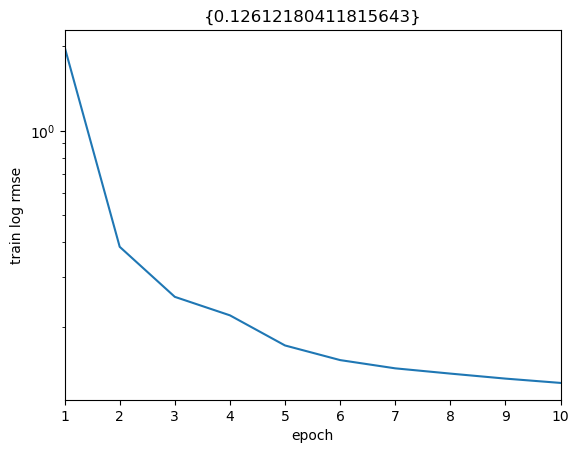

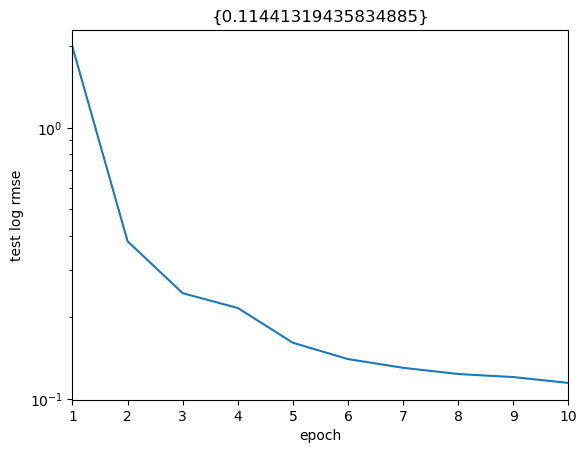

训练log rmse：0.126122
验证log rmse：0.114413


In [77]:
#预测
k,num_epochs,lr,weight_decay,batch_size=8,10,0.1,300,64
train_and_pred(train_datas, test_datas, train_labels, test_labels,
               num_epochs, lr, weight_decay, batch_size)

In [78]:
#模型选择
k,num_epochs,lr,weight_decay,batch_size=8,100,0.1,300,64
#train_l,valid_l=k_fold(k,train_alldatas,train_alllabels,num_epochs,lr,weight_decay,batch_size)
#print('%d-fold validation:avg trian rmse %f,avg valid rmse %f'%
 #     (k,train_l,valid_l))

In [80]:
net = get_net()
for i in range(1000):
    train_l,test_l = train(net, train_datas, train_labels, test_datas, test_labels,
                        num_epochs, lr, weight_decay, batch_size)
    if(i==0):
        min_test_l = test_l
        #如果当前结果较以前更优秀 保存结果
        preds=net(test_features).detach().numpy()

        test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
        submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
        submission.to_csv('./submission.csv',index=False)

    if(test_l[-1]<min_test_l[-1]):
        min_test_l = test_l
        print(min_test_l[-1])
        #如果当前结果较以前更优秀 保存结果
        preds=net(test_features).detach().numpy()

        test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
        submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
        submission.to_csv('./submission.csv',index=False)
min_test_l[-1]

0.10840561240911484